In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from adversarial_dataset import AdversarialDataset
import os
import matplotlib.pyplot as plt
from torchvision import models
from utils import correct_torch_image, minmax_scaler, denormalize
import numpy as np

In [2]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

noise_transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
dataset = AdversarialDataset(annotation_file="images.csv", 
                             categories_file="categories.csv", 
                             img_dir="images", 
                             noise_dir="adversarial_noise_untargeted", 
                             img_transform=transform)

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)


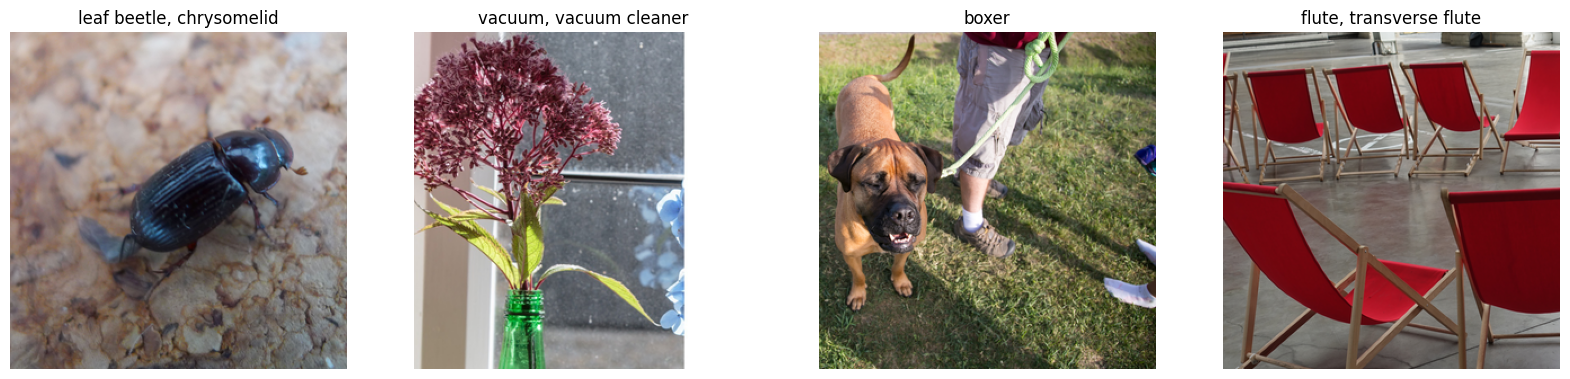

In [4]:
f, axarr = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    axarr[i].imshow(denormalize(correct_torch_image(dataset[i][0]), mean, std))
    axarr[i].axis('off')
    axarr[i].set_title(dataset.categories.loc[dataset.categories["CategoryId"] == dataset[i][2], "CategoryName"].values[0])
    
plt.savefig('figures/image_examples.png', bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


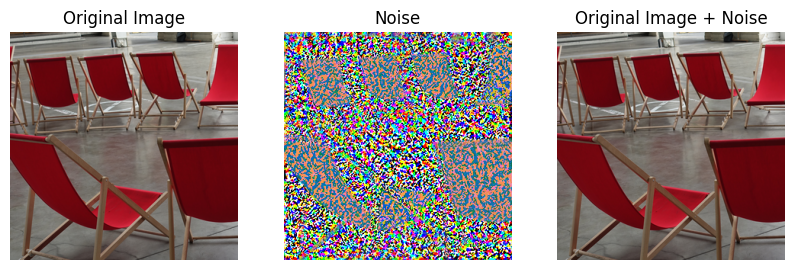

In [5]:
f, axarr = plt.subplots(1, 3, figsize=(10, 10))

axarr[0].imshow(denormalize(correct_torch_image(dataset[3][0]), mean, std))
axarr[0].axis('off')
axarr[0].set_title('Original Image')
axarr[1].imshow(correct_torch_image(minmax_scaler(dataset[3][1])))
axarr[1].axis('off')
axarr[1].set_title('Noise')
axarr[2].imshow(denormalize(correct_torch_image(dataset[3][0]) + correct_torch_image(dataset[3][1]), mean, std))
axarr[2].axis('off')
axarr[2].set_title('Original Image + Noise')

plt.savefig('figures/noise.png', bbox_inches="tight")

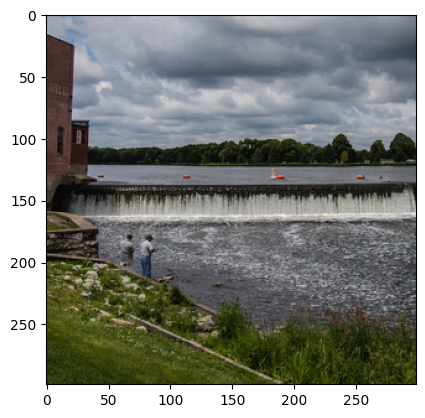

In [6]:
plt.imshow(denormalize(correct_torch_image(dataset[40][0]), mean, std))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


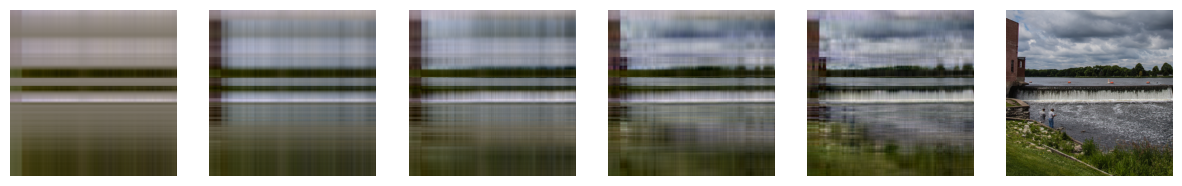

In [12]:
from sklearn.utils.extmath import randomized_svd

image = dataset[40][0]
img = np.concatenate([image[0, :, :].numpy(), image[1, :, :].numpy(), image[2, :, :].numpy()], axis=1)
_, _, WT = randomized_svd(img, n_components=299, random_state=0)

f, axarr = plt.subplots(1, 6, figsize=(15, 15))

for i, k in enumerate([1, 2, 3, 5, 10, 299]):
    WT_k = WT[:k, :]
    X_k = img @ WT_k.T @ WT_k

    final_image = np.stack([
        X_k[:, :image.shape[1]],
        X_k[:, image.shape[1]:image.shape[1]*2],
        X_k[:, image.shape[1]*2:image.shape[1]*3]
    ])
    final_image = torch.Tensor(final_image)
    
    axarr[i].imshow(denormalize(correct_torch_image(final_image), mean, std))
    axarr[i].axis('off')
    
    